# 1. Clustering

Clustering, or cluster analysis, is a methodology that allows you to find groups of similar objects, objects that are more related to each other than to objects in other groups. In general tehre are several types of clustering, first group: hard and soft; another group: based on prototypes, based on density and hierarchical clustering.

## 1.1 Hard clustering

Assume, that we have $X=\{x_i\}^{N}_{i=1}$, $x_i \in R^p$ - set of vectors with $p$ features. We aim to extract from this set $\Omega = (C_1, C_2, C_3, ..., C_K)$ - partitions composed of $K$ classes.

Partitions - sets s.t. $\forall i,j$ $C_i \cap C_j = \varnothing$ and $\cup_{k} C_k = \{x_1, x_2, ... , x_k\}$.

### K-means

The k-means algorithm belongs to the prototype-based clustering algorithms. Clustering based on prototypes means that each cluster is represented by a prototype, which can be either a centroid (middle) of similar points with continuous features, or a medoid (the most representative or most common point) in the case of categorical features.

#### Look at the simple example:

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from seaborn import scatterplot as scatter
from matplotlib import cm
%matplotlib inline

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
from fcmeans import FCM
from sklearn.metrics.pairwise import pairwise_distances_argmin

import warnings
warnings.simplefilter('ignore')

import time

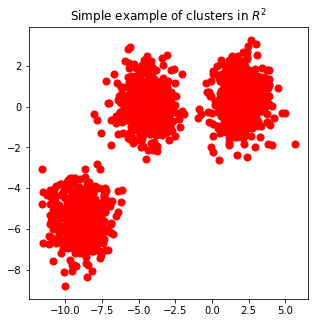

In [4]:
n_samples = 1500
random_state = 170
x, y = make_blobs(n_samples=n_samples, random_state=random_state)

plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1], c = 'red', s=50)
plt.grid
plt.title('Simple example of clusters in $R^2$')
plt.show()

#### How to find centroids of the clusters, which were mentioned before? 

We will use a special objetive function to find them:

$$\min_{\Omega =(C_1, ..., C_K)}\sum\limits_{k = 1}^{K}\sum\limits_{x_i \in C_k} ||x_i - m_k||^2,$$
where $m_k$ is best representativ of class $C_k$.

In simple words we minimize cumulative distance between each element of the cluster and cluster's centroid for each cluster.  

#### To achieve this in practice, the following algorithm is usually used:
* Fixe $(m_1, ... , m_k)$ and estimate $\Omega$
* Fixe $\Omega$ and estimante $(m_1, ... , m_k)$.

Describe each of these steps in details:

#### 1-st step: 

Initialize randomly $m_1, ..., m_k$ from $\{x_k\}_{i=1}^{N}$, then $C_k$ will be:
$$C_k = \{x_i | k = argmin_{k}||x_i - m_k||\}$$

For each centroid we try to find closest element.

#### 2-nd step:

For each class $C_1, ..., C_k$ estimate the best $m_1, ..., m_k.$ We assume, that $C_1, ..., C_k$ are independent.

How to estimate for givem $C_k$ the best $m_k$:
$$L_k = min_{m_k}\sum\limits_{x_i \in C_k} ||xi - m_k||.$$
We want to minimize this expression by $m_k$. To do that, take a derivative and equate the resulting expression to zero:
$$\frac{\partial L_k}{\partial m_k} = \sum\limits_{x_i \in C_k} - 2 ||xi - m_k|| = 0 \to$$
$$ - \sum\limits_{x_i \in C_k} x_i + m_k \sum\limits_{x_i \in C_k} 1 = 0 \to$$
$$m_k = \frac{1}{|C_k|}\sum\limits_{x_i \in C_k} x_i.$$

We got new centers, than we will repeat this steps until the syabilization of the classes. 

#### Properies

* Convergence ($\exists$ proof): always convergence, but not always to the global minimum.
* Not stable according to the initial data

To reduce the influence of the second property, the algorithm is usually repeated several times, and then choose the best classification (with the lowest value of objective function). 

#### Let's see how it looks in practice 
[Example from official documnetation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)

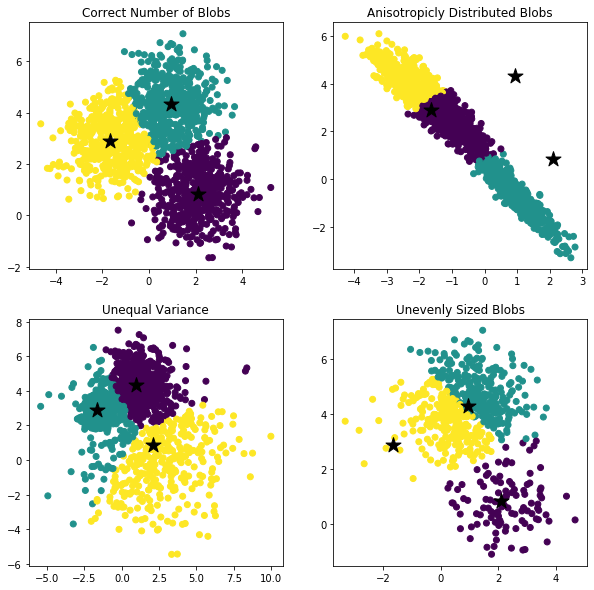

In [5]:
x, y = make_blobs(n_samples=1500, random_state=0)
km = KMeans(n_clusters=3, 
            init='random', #how we choose centroids at every step
            n_init=10, #how many times we want to repeat the algorithm 
            max_iter=300, #max iterations on one repetition of the algorithm
            tol=1e-04, #accuracy
            random_state=0) 
y_pred = km.fit_predict(x)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(x[:, 0], x[:, 1], c=y_pred)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='black')
plt.title("Correct Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
x_aniso = np.dot(x, transformation)
y_pred = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0).fit_predict(x_aniso)

plt.subplot(222)
plt.scatter(x_aniso[:, 0], x_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='black')

# Different variance
x_varied, y_varied = make_blobs(n_samples=1500,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=0)
y_pred = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0).fit_predict(x_varied)

plt.subplot(223)
plt.scatter(x_varied[:, 0], x_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='black')

# Unevenly sized blobs
x_filtered = np.vstack((x[y == 0][:500], x[y == 1][:100], x[y == 2][:10]))
y_pred = KMeans(n_clusters=3,init='random', n_init=10, max_iter=300, tol=1e-04,
                random_state=0).fit_predict(x_filtered)

plt.subplot(224)
plt.scatter(x_filtered[:, 0], x_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='black')

plt.show()

Another simple example, how to visualize clusters.

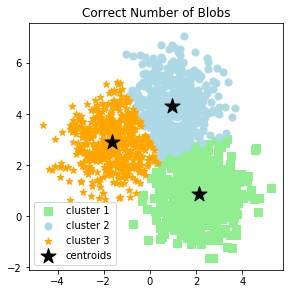

In [7]:
x, y = make_blobs(n_samples=1500, random_state=0)
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0) 
y_pred = km.fit_predict(x)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(x[y_pred == 0][:, 0], x[y_pred == 0][:, 1], s=50, c='lightgreen', marker='s', label = 'cluster 1')
plt.scatter(x[y_pred == 1][:, 0], x[y_pred == 1][:, 1], s=50, c='lightblue', marker='o', label = 'cluster 2')
plt.scatter(x[y_pred == 2][:, 0], x[y_pred == 2][:, 1], s=50, c='orange', marker='*', label = 'cluster 3')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='black', label = 'centroids')
plt.title("Correct Number of Blobs")
plt.legend()
plt.show()

### K-means++

As already noted, the centroids in the previous algorithm were selected randomly. But on practice we can choose centroids more cleverly. This is what the k-means++ algorithm proposes to do. The strategy is to place the initial centroids away from each other, use the following algorithm:

* Initialize set M for saving centroids
* Randomly choose the first centoid, save it in M
* For each $x_i$, which is not in M found the shortest distance to the centroids among all centroids from M.
* To choose next centroid, which will maximize the following expression:
$$\frac{max_i(min_M(||x_i-M||^2))}{\sum\limits_{i}min_M(||x_i-M||^2)}$$
* Repeat previous 3 steps, untill k centroids will be found. 
* Apply regular algorithm k-mean.

Note that in sklearn.cluster.KMeans by default used k-means++.

Look at another simple example of using KMeans.

In [8]:
digits = load_digits()
data = scale(digits.data)
k = len(np.unique(digits.target))

Reduce the size of data.

In [9]:
reduced_data = PCA(n_components=2).fit_transform(data)

print(f'Shape of initial data {data.shape}\nShape of reduced data {reduced_data.shape}.')

Shape of initial data (1797, 64)
Shape of reduced data (1797, 2).


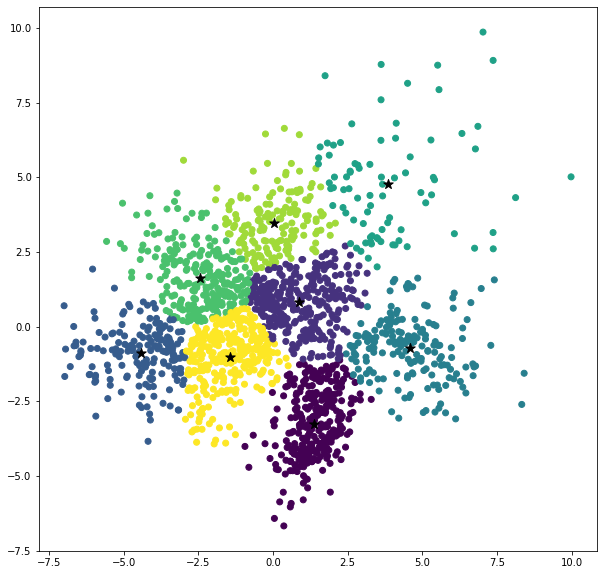

In [10]:
km = KMeans(n_clusters=8, n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_pred_dig = km.fit_predict(reduced_data)

plt.figure(figsize=(10,10))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_pred_dig)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=100, marker='*', c='black', label = 'centroids')
plt.show()

### K-means mini batch

Mini Batch K-means algorithm‘s main idea is to use small random batches of data of a fixed size, so they can be stored in memory. Each iteration a new random sample from the dataset is obtained and used to update the clusters and this is repeated until convergence. Each mini batch updates the clusters using a convex combination of the values of the prototypes and the data, applying a learning rate that decreases with the number of iterations. This learning rate is the inverse of the number of data assigned to a cluster during the process. As the number of iterations increases, the effect of new data is reduced, so convergence can be detected when no changes in the clusters occur in several consecutive iterations.
The empirical results suggest that it can obtain a substantial saving of computational time at the expense of some loss of cluster quality, but not extensive study of the algorithm has been done to measure how the characteristics of the datasets, such as the number of clusters or its size, affect the partition quality. (https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/)

In [11]:
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [12]:
# Compute clustering with Means
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# Compute clustering with MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

In [13]:
t_batch, t_mini_batch

(0.07488203048706055, 0.17381715774536133)

Compare results of k-means and k-means mini-batch. [Example from official documnetation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py)

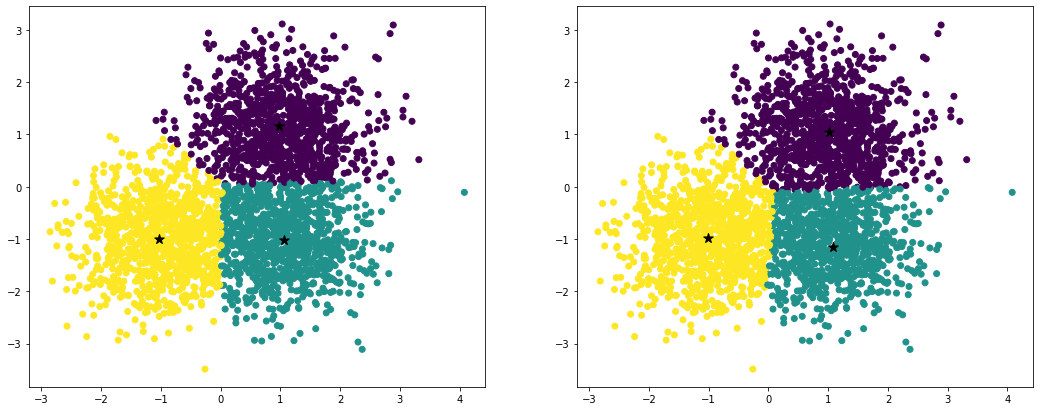

In [14]:
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

y_pred = pairwise_distances_argmin(X, k_means_cluster_centers)
y_pred_2 = pairwise_distances_argmin(X, mbk_means_cluster_centers)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.scatter(X[:,0], X[:,1], c=y_pred)
ax1.scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1], s=100, marker='*', c='black', label = 'centroids')

ax2.scatter(X[:,0], X[:,1], c=y_pred_2)
ax2.scatter(mbk.cluster_centers_[:,0], mbk.cluster_centers_[:,1], s=100, marker='*', c='black', label = 'centroids')

fig.show()

In [15]:
different = (y_pred_2 == 4)
for k in range(n_clusters):
    different += ((y_pred == k) != (y_pred_2 == k))

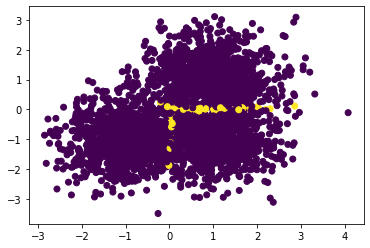

In [19]:
plt.scatter(X[:,0], X[:,1], c=different);

#### Summary

Algorithm:
* Select randomly/kmeans++ k representatives from $X$: $m_1, ... , m_k$.
* Assign each element $x_i$ to the closest representative
* Update the $m_k$ of each obtained cluster
* Iterste steps 2 and 3 untill stabilization

+/-
* Convergence, not always to the global minimum
* Not stable to the initial data (as it chooses randomly)
* Necessary to indicate the number of clusters k a priori
* Clusters are not overlapping and not hierarchical
* One or more clusters may be empty

The last problem solved in the realisation sklearn.cluster.KMeans, if the cluster is empty, then the algorithm will find the sample located at the greatest distance from the centroid of the empty cluster. Then he will make the centroid equal to this farthest point.